In [1]:
from pprint import pprint
# importing functions and modules useful for launching simulations
from main import get_options, get_min_mean_free_path, init_particles_in_system
from main import square, thruster
from main import CollisionHandler, DSMC
from main import scipy_integrate_solve_ivp, rk4, euler_explicit
from main import DataAnalyser, DataSaver
from main import available_particles
from main import post_processing
from main import convert_list_to_string
from collections import OrderedDict

In [2]:
debug = True

In [3]:
# defining paths to cfg 
main_cfg= 'cfg_files/main.cfg'
system_cfg = 'cfg_files/square.cfg' # square thruster tube
saving_cfg = 'cfg_files/saving.cfg'
simulation_cfg = 'cfg_files/simulation.cfg'
post_processing_cfg = 'cfg_files/post_processing.cfg'

list_cfg_files = [main_cfg, system_cfg, saving_cfg, simulation_cfg, post_processing_cfg]

cfg_path_dict = {
    'main':main_cfg,
    'system':system_cfg,
    'saving':saving_cfg,
    'simulation':simulation_cfg,
    'post_processing':post_processing_cfg
}

In [4]:
options = get_options(cfg_path_dict)
if(debug): pprint(options)

{'main': {'id_test': '1',
          'particles_densities': [1e+20],
          'particles_mean_number_per_cell': [1000],
          'particles_types': ['I'],
          'speed_param1': [0.0],
          'speed_param2': [200.0],
          'speed_type': ['gaussian'],
          'system_type': 'square'},
 'post_processing': {'compute_collisions': True,
                     'compute_hist_distribution_evolution': False,
                     'compute_spatial_distribution': False,
                     'compute_system_evolution': False,
                     'compute_temperature': True,
                     'files_to_merge': ['1'],
                     'frames_to_compute': ['first', 'last'],
                     'ids_test': ['1'],
                     'merge_csv': False,
                     'path': PosixPath('/home/paul/Documents/projects/Neutralisation_Faisceau_ions_negatifs_propulsion_satellite/results/test_1/params.csv')},
 'saving': {'path': PosixPath('/home/paul/Documents/projects/Neutralisati

## Building system

In [5]:
types = options['main']['particles_types']
charges = [available_particles[type_]['charge'] for type_ in types]
masses = [available_particles[type_]['mass'] for type_ in types]
effective_diameters = [available_particles[type_]['effective diameter'] for type_ in types]

min_mean_free_path = get_min_mean_free_path(effective_diameters = effective_diameters, particles_densities = options['main']['particles_densities'])

if(debug): 
    print('Types : {}'.format(types))
    print('Charges in C : {}'.format(charges))
    print('Masses in kg : {}'.format(masses))
    print('Effective diameters in m : {}'.format(effective_diameters))
    print('Min mean free path : {} m.'.format(min_mean_free_path))

Types : ['I']
Charges in C : [0]
Masses in kg : [2.35800283e-25]
Effective diameters in m : [4e-10]
Min mean free path : 0.01406744243995478 m.


In [6]:
system_type = options['main']['system_type']

if(system_type=='square'):
    system = square(options[system_type], min_mean_free_path)
    zone = None
    offset = [0,0]
    
elif(system_type=='thruster'):
    system = thruster(options[system_type], min_mean_free_path)
    zone = system.get_zone()
    offset = system.get_offset()

## Initializing particles

Space size : [0.0703372121997739, 0.0703372121997739, 0.1]
Resolution : [5, 5]
{'first particles': ['I particule of charge 0 C and mass 2.35800283e-25 kg in '
                     'position (0.021,0.002) m with speed (77.375,354.137) m/s',
                     'I particule of charge 0 C and mass 2.35800283e-25 kg in '
                     'position (0.021,0.011) m with speed (-283.535,28.74) m/s',
                     'I particule of charge 0 C and mass 2.35800283e-25 kg in '
                     'position (0.062,0.012) m with speed (26.232,-234.896) '
                     'm/s',
                     'I particule of charge 0 C and mass 2.35800283e-25 kg in '
                     'position (0.022,0.013) m with speed (187.913,-136.07) '
                     'm/s',
                     'I particule of charge 0 C and mass 2.35800283e-25 kg in '
                     'position (0.066,0.025) m with speed (135.221,-161.162) '
                     'm/s'],
 'mean speed': 318.17519205643384,
 'wa

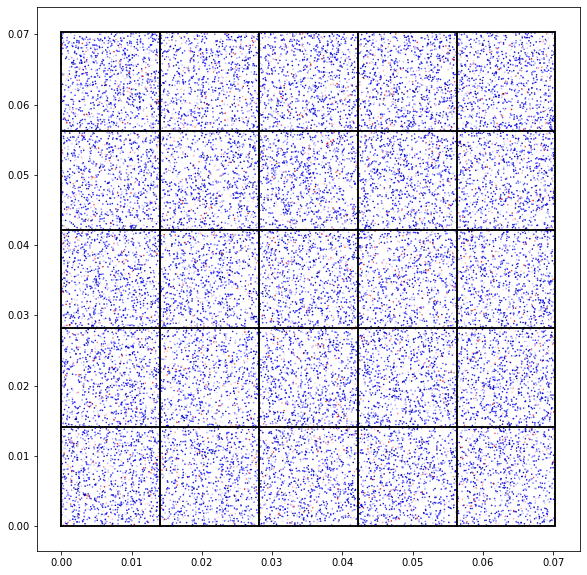

In [7]:
lx, ly, lz = system.get_size()
res_x, res_y = system.get_space_resolutions()
if(debug):
    print('Space size : {}'.format(system.get_size()))
    print('Resolution : {}'.format(system.get_space_resolutions()))
list_particles, vmean_exp = init_particles_in_system(**options['main'], space_size = [lx,ly], space_resolution=[res_x, res_y], zone = zone, offsets = offset, verbose = False, debug = False)
# adding particles to the grid
for particle in list_particles:
    system.add(particle)

    # TODO : do as Lui said - don't save it this way. (its okay for now)
if(system_type=='thruster'):
    system.set_sparsed_space()
    pprint("List of cases in the grid that are considered : {}".format(system.grid.sparsed_space_idx))
if(debug):
    pprint({
        'mean speed':vmean_exp,
        'first particles':[part.to_string() for part in list_particles][:5],
        'walls':system.get_walls()
    })
system.plot()

## Preping simulation

In [8]:
# update function
import numpy as np

if(system_type=='thruster'):
    from dolfin import Point

    def f(Y,t,m,q,zone,E):
        '''
        Renvoie la dérivée de Y en y (en faisant un bilan des forces notamment) pr être entré dans RK4
        Y=[x, y, z, vx, vy, vz] ce n'est pas le Y de liste_Y
        '''
        Ex, Ey = E.split(deepcopy=True)
        vx=Y[3]
        vy=Y[4]
        vz=Y[5]
        if zone.inside(Point(Y[0],Y[1])):
            ax = (1/m) * q * Ex(Y[0], Y[1])
            ay = (1/m) * q * Ey(Y[0], Y[1])
        else :
            ax = 0  #utile si les ki sont hors du mesh,
            ay = 0
        az=0
        return np.array([vx, vy, vz, ax, ay, az])
    
    args = [system.get_zone(), system.get_E()]
    
elif(system_type=='square'):
    def f(Y,t,m,q):
        vx=Y[3]
        vy=Y[4]
        vz=Y[5]

        ax = 0 
        ay = 0
        az = 0
        return np.array([vx, vy, vz, ax, ay, az])
    
    args = []

# DSMC params
N_particles_real = [int(density*lx*ly*lz) for density in options['main']['particles_densities']] # this is the REAL number of particles
N_particles_simu = [int(nb*res_x*res_y) for nb in options['main']['particles_mean_number_per_cell']]
Ne = [i/j for i, j in zip(N_particles_real,N_particles_simu)]

# TODO : see the adaptations for the DMSC with several species of particles

mean_speed = vmean_exp
DSMC_params = {
    'vr_max' : 2*mean_speed,
    'effective_diameter':  effective_diameters[0], # for now
    'Ne' : Ne[0], # this is the number of real particles one simulated particle represents.
    'cell_volume' : lx*ly*lz/(res_x*res_y), # since we are in 2D I don't really know what to add here actually... For now, I add the 3rd dimension rough size, that is l3
    'mean_particles_number_per_cell': sum(options['main']['particles_mean_number_per_cell']) # we don't account for the type
}

if(debug):
    pprint([N_particles_real, N_particles_simu, Ne, DSMC_params])
    
    
use_particles_collisions = False
use_DSMC = True

simu = options['simulation']
if(simu['scheme']=='euler_explicit'):
    integration_scheme = euler_explicit # scipy_integrate_solve_ivp , rk4 , euler_explicit
    # TODO : make a function get_scheme(str)
    
# TODO : include system instead of everything else here.
#collisionHandler = CollisionHandler(list_particles, system.get_walls(), f, eta = 0, p = 0, use_particles_collisions = use_particles_collisions, \
#        use_DSMC = use_DSMC, grid = system.get_grid(), DSMC_params = DSMC_params, integration_scheme=integration_scheme)
handler = DSMC(system = system, dsmc_params = DSMC_params, integration_scheme = integration_scheme, f = f)

[[49473234200360224],
 [25000],
 [1978929368014.409],
 {'Ne': 1978929368014.409,
  'cell_volume': 1.9789293680144093e-05,
  'effective_diameter': 4e-10,
  'mean_particles_number_per_cell': 1000,
  'vr_max': 636.3503841128677}]


## Launching Simulation

In [9]:
from tqdm import tqdm

min_mean_free_time = min_mean_free_path/mean_speed
dt = simu['dt']*min_mean_free_time
t = 0
MAX_INTEGRATION_STEP = simu['number_of_steps']
save_test = options['saving']['save']


In [10]:
if(save_test):
    saving_period = options['saving']['period']
    dir_saving = options['saving']['path']
    path_saving = dir_saving/(options['main']['id_test']+'.csv')
    params_dict = OrderedDict()
    
    # general :
    params_dict['id_test']= options['main']['id_test']
    params_dict['path_to_data'] = str(path_saving) # absolute path

    # on results of the simulation
    params_dict['number_of_collisions'] = '0'
    params_dict['mean_acceptance_rate'] = '0'
    params_dict['mean_proba'] = '0'
    params_dict['mean_vr_norm'] = '0'
    # on system =
    params_dict['nb_cells'] = str(system.get_number_of_cells())
    params_dict['volume'] = str(lx*ly*lz)
    params_dict['x_min'] = str(offset[0])
    params_dict['x_max'] = str(offset[0]+lx)
    params_dict['y_min'] = str(offset[1])
    params_dict['y_max'] = str(offset[1]+ly)
    # on particles =
    params_dict['total_number_of_particles'] = str(system.get_number_of_particles())
    params_dict['particles_types'] = convert_list_to_string(types)
    params_dict['particles_charges'] = convert_list_to_string(charges)
    params_dict['particles_masses'] = convert_list_to_string(masses)
    params_dict['particles_effective_diameters'] = convert_list_to_string(effective_diameters)
    params_dict['particles_densities'] = convert_list_to_string(options['main']['particles_densities']),
    params_dict['nb_parts_per_type'] = convert_list_to_string(N_particles_simu)
    params_dict['nb_parts_real_per_type'] = convert_list_to_string(N_particles_real)
    params_dict['Ne_per_type'] = convert_list_to_string(Ne)
    params_dict['mean_particles_number_per_cell_per_type'] = convert_list_to_string(options['main']['particles_mean_number_per_cell'])
        # deduction
    params_dict['min_mean_free_path'] = str(min_mean_free_path)
    params_dict['min_mean_free_time'] = str(min_mean_free_time)
        # on speed
    params_dict['speed_init_type'] = convert_list_to_string(options['main']['speed_type'])
    params_dict['v_mean'] = str(vmean_exp)
    params_dict['vr_max_init'] = str(DSMC_params['vr_max'])
    params_dict['vr_max_final'] = '0'

    # on simulation params =
    params_dict['dt'] = str(dt)
    params_dict['MAX_INTEGRATION_STEP'] = str(MAX_INTEGRATION_STEP)
    params_dict['integration_scheme'] = integration_scheme.__name__
    #'eta'= eta
    #'loss_charge_proba' = p
        
    # on saving params
    params_dict['saving_period'] = str(saving_period) 
                
    if(debug): pprint(params_dict)
    data_analyser = DataSaver(list_particles, name_test = options['main']['id_test']+'.csv', saving_directory = dir_saving)
    data_analyser.save_test_params(dir_saving/'params.csv', params_dict, use_saving_directory = True)

OrderedDict([('id_test', '1'),
             ('path_to_data',
              '/home/paul/Documents/projects/Neutralisation_Faisceau_ions_negatifs_propulsion_satellite/results/test_1/1.csv'),
             ('number_of_collisions', '0'),
             ('mean_acceptance_rate', '0'),
             ('mean_proba', '0'),
             ('mean_vr_norm', '0'),
             ('nb_cells', '30'),
             ('volume', '0.0005936788104043228'),
             ('x_min', '0'),
             ('x_max', '0.04220232731986434'),
             ('y_min', '0'),
             ('y_max', '0.1406744243995478'),
             ('total_number_of_particles', '30000'),
             ('particles_types', 'I'),
             ('particles_charges', '0'),
             ('particles_masses', '2.35800283e-25'),
             ('particles_effective_diameters', '4e-10'),
             ('particles_densities', ('1e+20',)),
             ('nb_parts_per_type', '30000'),
             ('nb_parts_real_per_type', '59367881040432272'),
             ('Ne_p

In [11]:

if(save_test): # before starting simulation
        data_analyser.save_everything_to_one_csv(erase = True)
        
for k in tqdm(range(MAX_INTEGRATION_STEP)): #
    #if(debug): print("\nStep {} over {}...\n".format(k+1, MAX_INTEGRATION_STEP))
    handler.step(dt, t, args)
    t+=dt
    if(save_test and (k%saving_period==0 or (k == MAX_INTEGRATION_STEP-1 and k%saving_period!=0))):
        data_analyser.save_everything_to_one_csv()
        handler.save_collisions_matrix(name = dir_saving/("test_"+params_dict['id_test']+"_collision_matrix.txt"), iteration = k)
    
# last saving

number_of_collisions = handler.get_collisions_count()
mean_acceptance_rate = handler.get_acceptance_rate()
mean_vr_norm = handler.get_mean_vr_norm()
vr_max_final = handler.get_vr_norm()
mean_proba = handler.get_mean_proba()

# saving again to the csv.
params_dict['mean_proba']=str(mean_proba)
params_dict['number_of_collisions']=str(number_of_collisions)
params_dict['mean_acceptance_rate']=str(mean_acceptance_rate)
params_dict['mean_vr_norm']=str(mean_vr_norm)
params_dict['vr_max']=str(vr_max_final)
if(debug): pprint(params_dict)
data_analyser.update_saved_params(dir_saving/'params.csv', params_dict, use_saving_directory = False)


100%|██████████| 300/300 [18:47<00:00,  3.76s/it]

OrderedDict([('id_test', '1'),
             ('path_to_data',
              '/home/paul/Documents/projects/Neutralisation_Faisceau_ions_negatifs_propulsion_satellite/results/test_1/1.csv'),
             ('number_of_collisions', '443612'),
             ('mean_acceptance_rate', '0.2795959708007851'),
             ('mean_proba', '0.2795011783989844'),
             ('mean_vr_norm', '408.9615628135724'),
             ('nb_cells', '30'),
             ('volume', '0.0005936788104043228'),
             ('x_min', '0'),
             ('x_max', '0.04220232731986434'),
             ('y_min', '0'),
             ('y_max', '0.1406744243995478'),
             ('total_number_of_particles', '30000'),
             ('particles_types', 'I'),
             ('particles_charges', '0'),
             ('particles_masses', '2.35800283e-25'),
             ('particles_effective_diameters', '4e-10'),
             ('particles_densities', ('1e+20',)),
             ('nb_parts_per_type', '30000'),
             ('nb_parts_re

In [5]:
# post processing
#if(save_test): # before starting simulation
post_processing(options['post_processing'])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Equilibrium variance = 18086.624810538193 m2/s2
T_0 = 17810.34303416445 K
For test 1, N_e = 8.778768e+17 vs N_t = 2.2262955390162112e+18.


<Figure size 720x720 with 0 Axes>

In [13]:
from shutil import copyfile, copy 
from os import mkdir
if(save_test):
    for file in list_cfg_files:
        copy(src = file, dst = dir_saving/"cfg_files/")